In [1]:
from brian2 import *
import sbi.utils
import sbi.analysis
import sbi.inference
import torch

In [2]:
defaultclock.dt = 0.05*ms

In [3]:
def simulate(params, I=1*nA, t_on=50*ms, t_total=350*ms):
    """
    Simulates the HH model with brian2 for parameter sets in params and the
    given input current (injection of I between t_on and t_total - t_on).

    Returns a dictionary {'t': time steps, 'v': voltage, 'I_inj': current,
                          'spike_count': spike count}.
    """
    assert t_total > 2 * t_on
    t_off = t_total - t_on
    
    params = np.atleast_2d(params)
    
    gleak = 10*nS
    Eleak = -70*mV
    VT = -60.0*mV
    C = 200*pF
    ENa = 53*mV
    EK = -107*mV

    eqs = '''
         dVm/dt = -(gNa*m**3*h*(Vm - ENa) + gK*n**4*(Vm - EK) + gleak*(Vm - Eleak) - I_inj) / C : volt
         I_inj = int(t >= t_on and t < t_off)*I : amp (shared)
         dm/dt = alpham*(1-m) - betam*m : 1
         dn/dt = alphan*(1-n) - betan*n : 1
         dh/dt = alphah*(1-h) - betah*h : 1

         alpham = (-0.32/mV) * (Vm - VT - 13.*mV) / (exp((-(Vm - VT - 13.*mV))/(4.*mV)) - 1)/ms : Hz
         betam = (0.28/mV) * (Vm - VT - 40.*mV) / (exp((Vm - VT - 40.*mV)/(5.*mV)) - 1)/ms : Hz

         alphah = 0.128 * exp(-(Vm - VT - 17.*mV) / (18.*mV))/ms : Hz
         betah = 4/(1 + exp((-(Vm - VT - 40.*mV)) / (5.*mV)))/ms : Hz

         alphan = (-0.032/mV) * (Vm - VT - 15.*mV) / (exp((-(Vm - VT - 15.*mV)) / (5.*mV)) - 1)/ms : Hz
         betan = 0.5*exp(-(Vm - VT - 10.*mV) / (40.*mV))/ms : Hz
         # The parameters to fit
         gNa : siemens (constant)
         gK : siemens (constant)
         '''
    neurons = NeuronGroup(params.shape[0],
                          eqs,
                          threshold='m>0.5', refractory='m>0.5',
                          method='exponential_euler',
                          name='neurons')
    Vm_mon = StateMonitor(neurons, 'Vm', record=True, name='Vm_mon')
    spike_mon = SpikeMonitor(neurons, record=False, name='spike_mon')
    neurons.gNa_ = params[:, 0]*uS
    neurons.gK = params[:, 1]*uS
    neurons.Vm = 'Eleak'
    neurons.m = '1/(1 + betam/alpham)'
    neurons.h = '1/(1 + betah/alphah)'
    neurons.n = '1/(1 + betan/alphan)'

    run(t_total)
    
    I_inj = ((Vm_mon.t >= t_on) & (Vm_mon.t < t_off))*I
    return dict(v=Vm_mon.Vm,
                t=Vm_mon.t,
                I_inj=I_inj,
                spike_count=spike_mon.count)

In [4]:
# true params
true_params = np.array([[32., 1.]])  # (gNa, gK) in µS 

# prior distribution over parameters
prior_min = [.5, 1e-4]  # (gNa, gK) in µS
prior_max = [80.,15.]   # (gNa, gK) in µS
prior = sbi.utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min),
                                        high=torch.as_tensor(prior_max))

# samples from the prior distribution
theta = prior.sample((10_000, ))

# Summary stats

In [5]:
def calculate_summary_statistics(x):
    """Calculate summary statistics for results in x"""
    I_inj = x["I_inj"]
    v = x["v"]/mV
    
    spike_count = x["spike_count"]
    v_active = v[:, I_inj > 0*nA]
    mean_active = np.mean(v_active, axis=1)
    std_active = np.std(v_active, axis=1)
    max_v = np.max(v_active, axis=1)

    sum_stats = np.vstack((spike_count, mean_active, std_active, max_v))
    return sum_stats.T


def simulation_wrapper_summary_stats(params):
    """
    Returns summary statistics from conductance values in params.
    Summarizes the output of the simulation and converts it to torch.Tensor.
    """
    obs = simulate(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))
    return summstats.to(torch.float32)

In [6]:
# summary statistics
x = simulation_wrapper_summary_stats(theta.numpy())

# instantiate and train neural density estimator based on SNPE algorithm
density_estimator_build_fun = sbi.utils.posterior_nn(model='mdn')
inference = sbi.inference.SNPE(prior,
                               density_estimator=density_estimator_build_fun)
inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

Neural network successfully converged after 124 epochs.


In [7]:
# ground truth data
true_data = simulate(true_params)
x_o = calculate_summary_statistics(true_data)

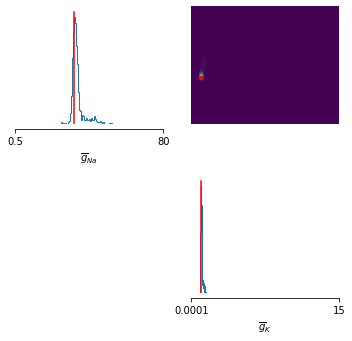

In [8]:
# plot estimated posterior distribution
samples = posterior.sample((1000, ), x=x_o, show_progress_bars=False)
labels_params = [r'$\overline{g}_{Na}$', r'$\overline{g}_{K}$']
sbi.analysis.pairplot(samples,
                      limits=[[.5, 80], [1e-4, 15.]],
                      ticks=[[.5, 80], [1e-4, 15.]],
                      figsize=(5, 5),
                      points=true_params,
                      labels=labels_params,
                      points_offdiag={'markersize': 6},
                      points_colors=['r'])
plt.tight_layout();

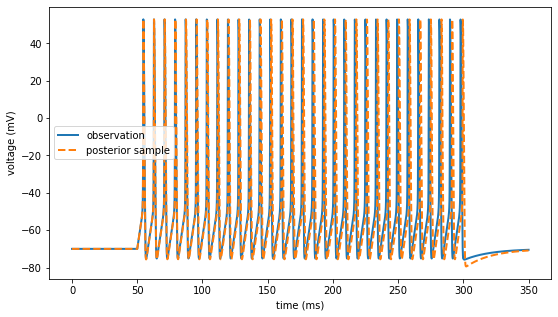

In [9]:
# ground truth data
t = true_data['t']
I_inj = true_data['I_inj']
v = true_data['v']

# draw a single sample from the posterior
posterior_sample = posterior.sample((1,), x=x_o, show_progress_bars=False)
obs = simulate(posterior_sample.numpy())

# plot observation and sample
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(t/ms, v[0, :]/mV, lw=2, label='observation')
ax.plot(t/ms, obs['v'][0, :]/mV, '--', lw=2, label='posterior sample')
ax.legend()
ax.set(xlabel='time (ms)', ylabel='voltage (mV)');

# Raw output

In [10]:
def simulation_wrapper_raw_output(params):
    """
    Returns voltage traces from conductance values in `params` and converts
    it to torch.Tensor.
    """
    obs = simulate(params)
    v = torch.as_tensor(obs["v"]/mV)
    return v.to(torch.float32)

In [11]:
# voltage traces
x = simulation_wrapper_raw_output(theta.numpy())

# instantiate and train neural density estimator based on SNPE algorithm
density_estimator_build_fun = sbi.utils.posterior_nn(model='mdn')
inference = sbi.inference.SNPE(prior,
                               density_estimator=density_estimator_build_fun)
inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

Neural network successfully converged after 97 epochs.


In [12]:
# true voltage traces
x_o = simulation_wrapper_raw_output(true_params)

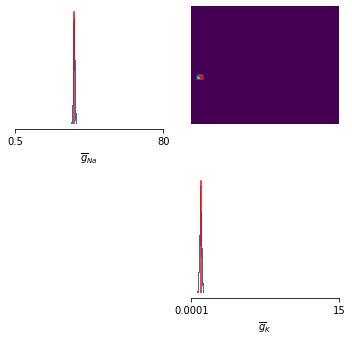

In [13]:
# plot estimated posterior distribution
samples = posterior.sample((1000,), x=x_o, show_progress_bars=False)
labels_params = [r'$\overline{g}_{Na}$', r'$\overline{g}_{K}$']
sbi.analysis.pairplot(samples,
                      limits=[[.5, 80], [1e-4, 15.]],
                      ticks=[[.5, 80], [1e-4, 15.]],
                      figsize=(5, 5),
                      points=true_params,
                      labels=labels_params,
                      points_offdiag={'markersize': 6},
                      points_colors=['r'])
plt.tight_layout();

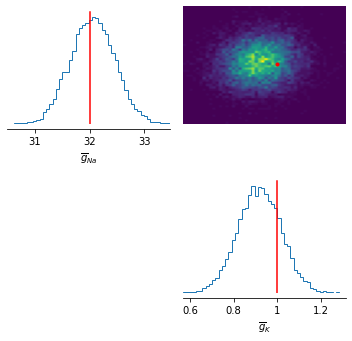

In [14]:
# zoom in and plot estimated posterior distribution
samples = posterior.sample((10000,), x=x_o, show_progress_bars=False)
labels_params = [r'$\overline{g}_{Na}$', r'$\overline{g}_{K}$']
sbi.analysis.pairplot(samples,
                      figsize=(5, 5),
                      points=true_params,
                      labels=labels_params,
                      points_offdiag={'markersize': 6},
                      points_colors=['r'])
plt.tight_layout();

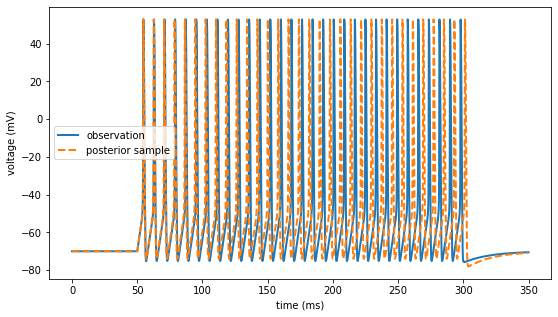

In [15]:
# Draw a single sample from the posterior and convert to numpy for plotting.
posterior_sample = posterior.sample((1,), x=x_o,
                                    show_progress_bars=False).numpy()
x = simulate(posterior_sample)

# plot observation and sample
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(t/ms, v[0, :]/mV, lw=2, label='observation')
ax.plot(t/ms, x['v'][0, :]/mV, '--', lw=2, label='posterior sample')
ax.legend()
ax.set(xlabel='time (ms)', ylabel='voltage (mV)');